1. Identifying Non-Uniform Illumination
How to check?

Histogram Analysis: Compute the histogram of pixel intensities. If the distribution is skewed or has multiple peaks, there might be illumination issues.

Edge Detection: Use Sobel or Canny edge detection. If edges appear stronger in one part of the image and weak in another, the lighting may be uneven.

Mean and Standard Deviation of Brightness: Calculate the mean intensity in different image regions. Large variations indicate uneven lighting.
How to prove it?

Compare histograms of images taken at different times. If illumination is consistent, they should have similar distributions.
Convert to grayscale and visualize the intensity heatmap. Uneven patches indicate lighting issues


How This Works:
1.	Histogram Analysis: 
o	The intensity distribution is checked for skewness or multiple peaks.
2.	Mean & Standard Deviation: 
o	The image is split into four regions, and their brightness levels are compared.
3.	Edge Detection: 
o	Sobel filter detects inconsistencies in lighting by highlighting areas with strong vs. weak edges.
4.	Heatmap Visualization: 
o	Provides a visual representation of brightness variations.


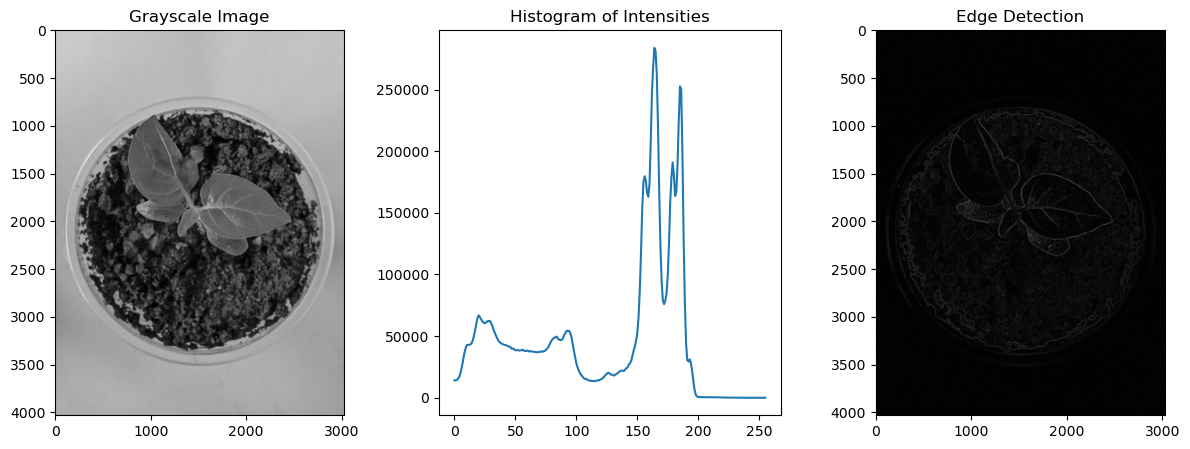

Region 1: Mean=136.15, Std Dev=58.10
Region 2: Mean=137.75, Std Dev=58.19
Region 3: Mean=108.82, Std Dev=61.28
Region 4: Mean=112.60, Std Dev=54.90


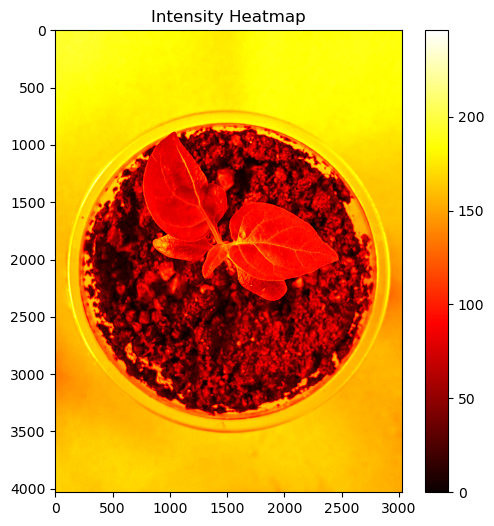

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_illumination(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Compute histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    
    # Compute mean and standard deviation in different regions
    h, w = img.shape
    regions = [img[:h//2, :w//2], img[:h//2, w//2:], img[h//2:, :w//2], img[h//2:, w//2:]]
    stats = [(np.mean(region), np.std(region)) for region in regions]
    
    # Edge detection using Sobel
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.hypot(sobelx, sobely)
    
    # Show results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Grayscale Image")
    
    ax[1].plot(hist)
    ax[1].set_title("Histogram of Intensities")
    
    ax[2].imshow(edges, cmap='gray')
    ax[2].set_title("Edge Detection")
    
    plt.show()
    
    # Print statistics
    for i, (mean, std) in enumerate(stats):
        print(f"Region {i+1}: Mean={mean:.2f}, Std Dev={std:.2f}")
    
    # Heatmap visualization
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap='hot')
    plt.colorbar()
    plt.title("Intensity Heatmap")
    plt.show()


analyze_illumination("plant_image_3.jpg")


2. Detecting Salt-and-Pepper Noise (Impulse Noise)
How to check?
•	Zoom in and visually inspect: Look for white and black pixels scattered randomly.
•	Variance in Local Patches: Compute local variance in small window regions. High variance in small patches suggests impulse noise.
•	Apply Median Filter and Subtract: If a median filter significantly changes the image, impulse noise is likely present.
How to prove it?
•	Compute the percentage of pixels with extremely low (0) or high (255) intensity. If there are outliers, it's likely salt-and-pepper noise.



How to Interpret the Output
1.	If the noise percentage is high (e.g., > 5%), the image has a lot of salt-and-pepper noise.
2.	The difference image should highlight only noise pixels—if it affects other areas, the image may have other types of noise too.
Why This Works?
•	Salt-and-pepper noise creates sudden intensity jumps (0 to 255).
•	A median filter is effective because it replaces extreme values with a more representative one from surrounding pixels.
•	Absolute difference calculation helps visualize and quantify the noise.



Salt-and-Pepper Noise Percentage: 0.12%


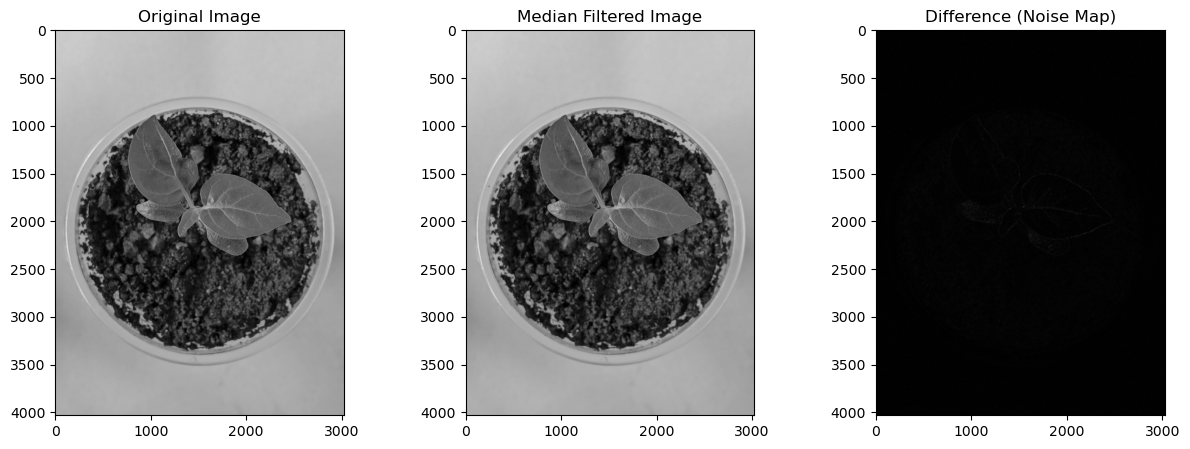

In [2]:
def detect_salt_and_pepper_noise(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Compute percentage of salt-and-pepper noise
    total_pixels = img.size
    salt_pepper_pixels = np.sum((img == 0) | (img == 255))
    noise_percentage = (salt_pepper_pixels / total_pixels) * 100
    
    print(f"Salt-and-Pepper Noise Percentage: {noise_percentage:.2f}%")
    
    # Apply median filter and compute difference
    filtered_img = cv2.medianBlur(img, 3)
    diff = cv2.absdiff(img, filtered_img)
    
    # Show results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Original Image")
    
    ax[1].imshow(filtered_img, cmap='gray')
    ax[1].set_title("Median Filtered Image")
    
    ax[2].imshow(diff, cmap='gray')
    ax[2].set_title("Difference (Noise Map)")
    
    plt.show()


detect_salt_and_pepper_noise("plant_image_3.jpg")

3. Detecting Gaussian Noise
How to check?
•	Histogram Spread: Gaussian noise causes a broader intensity histogram compared to a clean image.
•	Fourier Transform Analysis: High-frequency random components indicate noise.
•	Difference Image: Subtract a denoised version (like a blurred image) from the original to reveal noise patterns.
How to prove it?
•	Measure the Signal-to-Noise Ratio (SNR): Lower values indicate high noise levels.


What Level is Considered Noise?
•	High SNR (≥ 30 dB): Signal is much stronger than noise → Clean image/data
•	Moderate SNR (20–30 dB): Some noise is present, but signal is still dominant → Acceptable quality
•	Low SNR (10–20 dB): Noise is significant and affects details → Noticeable degradation
•	Very Low SNR (< 10 dB): Noise is overwhelming the signal → Poor quality


Signal-to-Noise Ratio (SNR): 19.20 dB


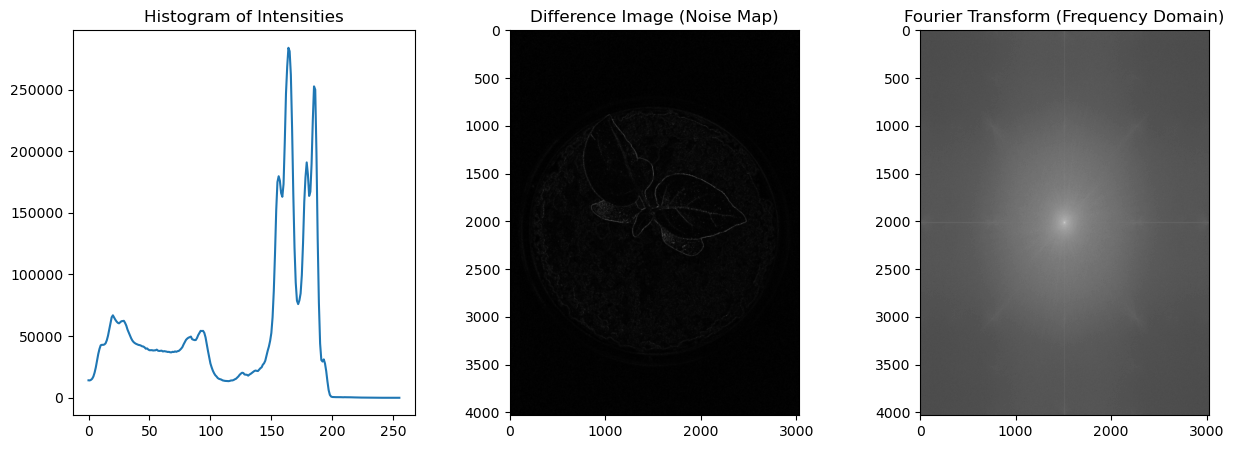

In [3]:
def detect_gaussian_noise(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Compute histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    
    # Apply Gaussian blur and compute difference
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
    diff = cv2.absdiff(img, blurred_img)
    
    # Compute Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    
    # Compute SNR (Signal-to-Noise Ratio)
    signal_power = np.mean(img ** 2)
    noise_power = np.mean(diff ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")
    
    # Show results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(hist)
    ax[0].set_title("Histogram of Intensities")
    
    ax[1].imshow(diff, cmap='gray')
    ax[1].set_title("Difference Image (Noise Map)")
    
    ax[2].imshow(magnitude_spectrum, cmap='gray')
    ax[2].set_title("Fourier Transform (Frequency Domain)")
    
    plt.show()


detect_gaussian_noise("plant_image_3.jpg")

4. Detecting Blur (Motion Blur or Defocus)
How to check?
•	Edge Sharpness Test: Use the Laplacian variance method—sharp images have high variance, while blurred images have low variance.
•	Frequency Domain Analysis: Blur reduces high-frequency details in the image’s Fourier transform.
•	Structural Similarity Index (SSIM) vs. a Reference Image: Compare with a sharp reference frame from your time-lapse.
How to prove it?
•	Compute the Laplacian variance
•	If the value is low, the image is blurry.

Interpreting Laplacian Variance
•	High variance (> 1500–2000): Sharp image (clear edges, minimal blur)
•	Moderate variance (500–1500): Slightly blurry image
•	Low variance (< 500): Very blurry image (low edge definition)

What Level is Considered "Noisy"?
1.	If Laplacian variance is very high (> 3000) and the image still looks unclear, it might be due to noise rather than sharp details.
2.	If the variance is low (< 500) but SNR is also low (< 20 dB), it's likely that the image is both blurry and noisy.
3.	A clean, sharp image should have a reasonable Laplacian variance (1000–2500) and a high SNR (> 30 dB).




In [4]:
def detect_blur(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian_var

blur_value = detect_blur("plant_image_3.jpg")
print(f"Laplacian Variance: {blur_value}")

Laplacian Variance: 11.860889667992705
